In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper

MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250402-092247-StopOpenEarly_6_v3.1"

MODEL_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")

venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)

model = PPO.load(MODEL_PATH,
                    env=venv, 
                    print_system_info=True,
                    custom_objects={
                        "ViT":ViT,
                    })

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

net = model.policy
vit = net.mlp_extractor.policy_net[1]
vit


2025-05-12 10:31:05.683083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-12 10:31:05.683162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-12 10:31:05.719925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 10:31:05.806383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 10:31:06.746891: W tensorflow/compiler/tf2

building procgen...done
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(50000, 64, 64, 9)


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=144, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1152, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Layer

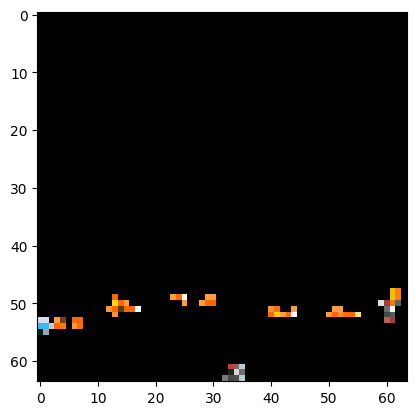

In [2]:
import matplotlib.pyplot as plt

INDEX = 110

plt.imshow(observations[INDEX][:,:,6:])

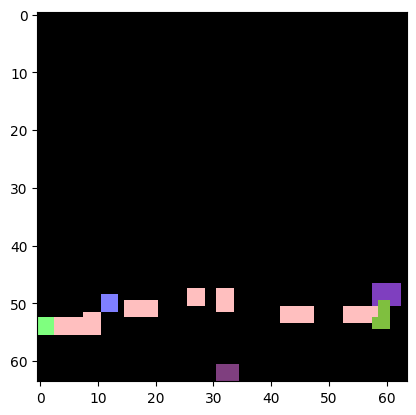

In [3]:
plt.imshow(seg_observations[INDEX][:,:,:])

In [4]:
seg_observations.shape

(50000, 64, 64, 3)

In [5]:
seg_observations.reshape(-1, seg_observations.shape[3]).shape

(204800000, 3)

In [6]:
# # (10000, 64, 64, 3)
# unique_colors = np.unique(seg_observations.reshape(-1, seg_observations.shape[3]), axis=0)
# unique_colors, unique_colors.shape

In [7]:
UNIQUE_COLORS = np.array([[  0,   0,   0],
        [127,  63, 127],
        [127,  63, 191],
        [127, 127, 255],
        [127, 191,  63],
        [127, 255, 127],
        [191, 255, 255],
        [255, 127, 127],
        [255, 191, 191],
        [255, 191, 255]], dtype=np.uint8)[np.newaxis]
UNIQUE_COLORS = np.squeeze(UNIQUE_COLORS, axis=0)
UNIQUE_COLORS.shape

(10, 3)

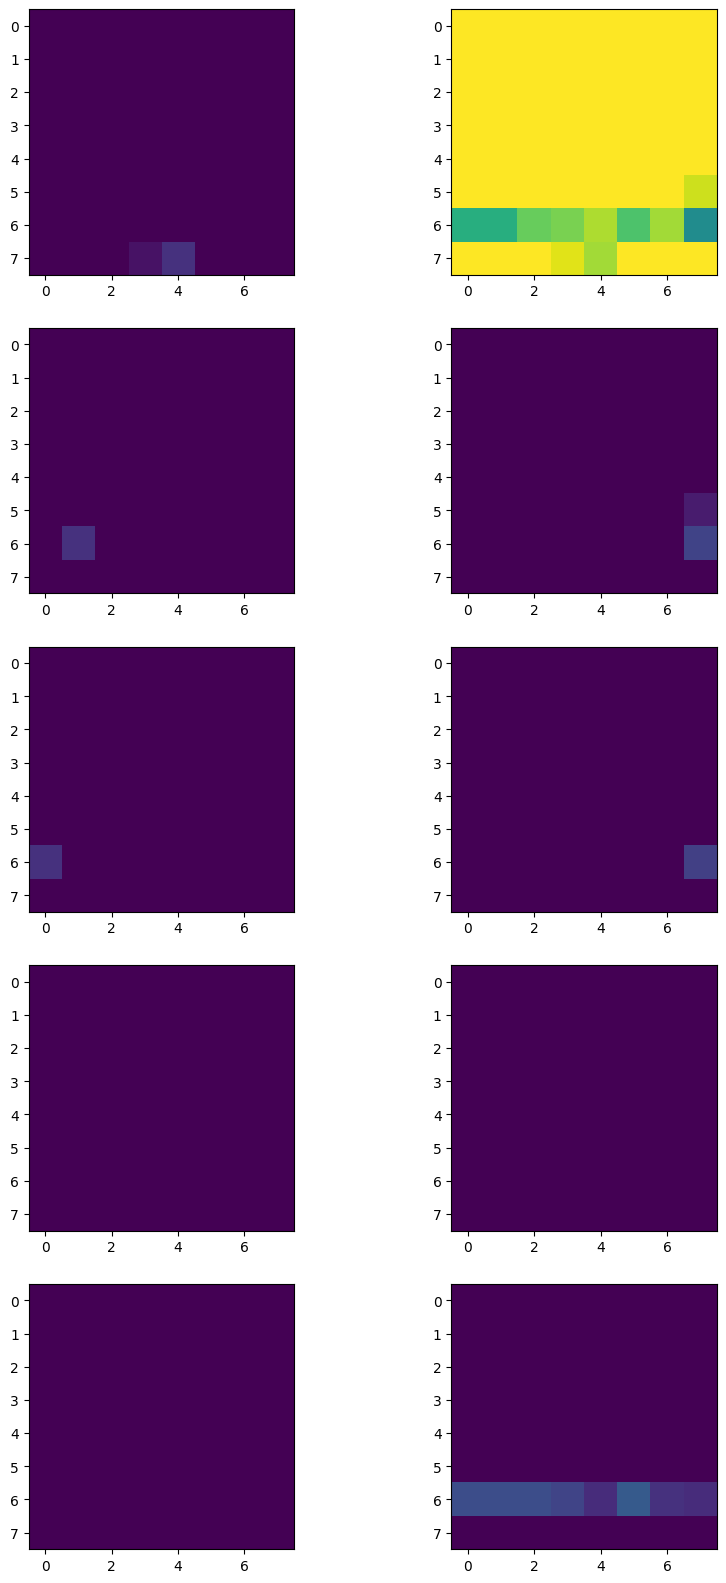

In [8]:
POOLER = nn.AvgPool2d(kernel_size=8, stride=8)

def segments_to_map(segment):
    encoded_segments = np.zeros((64, 64, len(UNIQUE_COLORS)), dtype=np.float32)

    for i in range(len(UNIQUE_COLORS)):
        mono = np.all(segment == UNIQUE_COLORS[i, :], axis=2)
        mono = mono.astype(np.float32)
        encoded_segments[:, :, i] = mono
    # resize to 16x16
    channels = POOLER(th.tensor(encoded_segments).permute(2, 0, 1)).permute(1, 2, 0).numpy()
    return channels


segmented = [
    segments_to_map(seg_observations[INDEX])
]

segmented = np.array(segmented)
segmented.shape

# subplots 7x2
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    axs[i, 1].imshow(segmented[0][:,:,2*i], vmin=0, vmax=1)
    axs[i, 0].imshow(segmented[0][:,:,2*i+1], vmin=0, vmax=1)

In [9]:
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

extractor = Extractor(vit).cpu()
recorder = Recorder(vit).cpu()

def attention_map(attention):
    # avg attention over heads
    attention = np.array(attention).mean(axis=1)

    grid_size = int(np.sqrt(attention.shape[-1] - 1))
    num_layers = attention.shape[0]
    num_heads = attention.shape[1]
    reshaped = attention.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = mask / mask.max()
    return mask.reshape(grid_size, grid_size)

In [10]:
observations.shape[0]

50000

In [11]:
from tqdm import tqdm
# calculate attention map for all samples
attention_maps = []
BATCH_SIZE = 2
for i in tqdm(range(0, observations.shape[0], BATCH_SIZE)):
    end = min(i + BATCH_SIZE, observations.shape[0])
    batch_size = end - i
    
    batch_obs = observations[i:end]
    obs_batch = th.tensor(batch_obs).reshape(batch_size, 64, 64, 9).permute(0, 3, 1, 2).float().cpu()
    
    with th.no_grad():
        probas_batch, attention_batch = recorder(obs_batch)
        attention_batch = attention_batch.cpu().detach().numpy()

    for j in range(batch_size):
        attn_map = attention_map(attention_batch[j][np.newaxis])
        attention_maps.append(attn_map)
    
    del obs_batch, probas_batch, attention_batch
    if i % 100 == 0:
        th.cuda.empty_cache()

100%|██████████| 25000/25000 [06:54<00:00, 60.31it/s]


In [12]:
attention_maps = np.array(attention_maps)

In [13]:
POOLER_SMALL = nn.AvgPool2d(kernel_size=2, stride=2)



attention_maps_segmented = []
for i in tqdm(range(len(attention_maps))):
    attention_maps_segmented.append(POOLER_SMALL(th.tensor(attention_maps[i].reshape(16,16,1)).permute(2, 0, 1)).permute(1, 2, 0).numpy())
attention_maps_segmented = np.array(attention_maps_segmented)
attention_maps_segmented.shape

100%|██████████| 50000/50000 [00:01<00:00, 45778.76it/s]


(50000, 8, 8, 1)

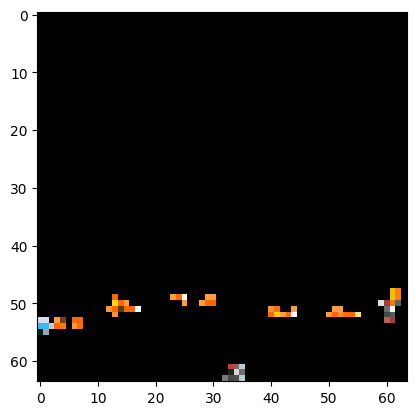

In [14]:
plt.imshow(observations[INDEX][:,:,6:])

In [15]:
segmented.shape

(1, 8, 8, 10)

In [16]:
segmented[0]

array([[[1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ],
        [1.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      ]],

       [[1.      , 0.      , 0.      , 0.     

# Figure out what each class means

In [17]:
segmented[0].shape

(8, 8, 10)

In [18]:
import tqdm

segmented = []
for i in tqdm.tqdm(range(len(seg_observations))):
    segmented.append(segments_to_map(seg_observations[i]))
segmented = np.array(segmented)
segmented.shape

100%|██████████| 50000/50000 [00:54<00:00, 916.28it/s] 


(50000, 8, 8, 10)

In [19]:
# find for each segment class an example of observation, and segment (2x14) plots

# find one sample in segmented dataset where the given segment class is present
def find_segment_class_in_dataset(seg_class):
    if np.sum(segmented[INDEX][:,:,seg_class]) > 0:
        return INDEX
    for i in range(segmented.shape[0]):
        if np.sum(segmented[i][:,:,seg_class]) > 0:
            return i
    return -1

examples = []

for i in range(10):
    index = find_segment_class_in_dataset(i)
    if index != -1:
        examples.append(index)
    else:
        examples.append(-1)

print(examples)

[110, 110, 110, 110, 110, 110, 24, 22, 110, 20]


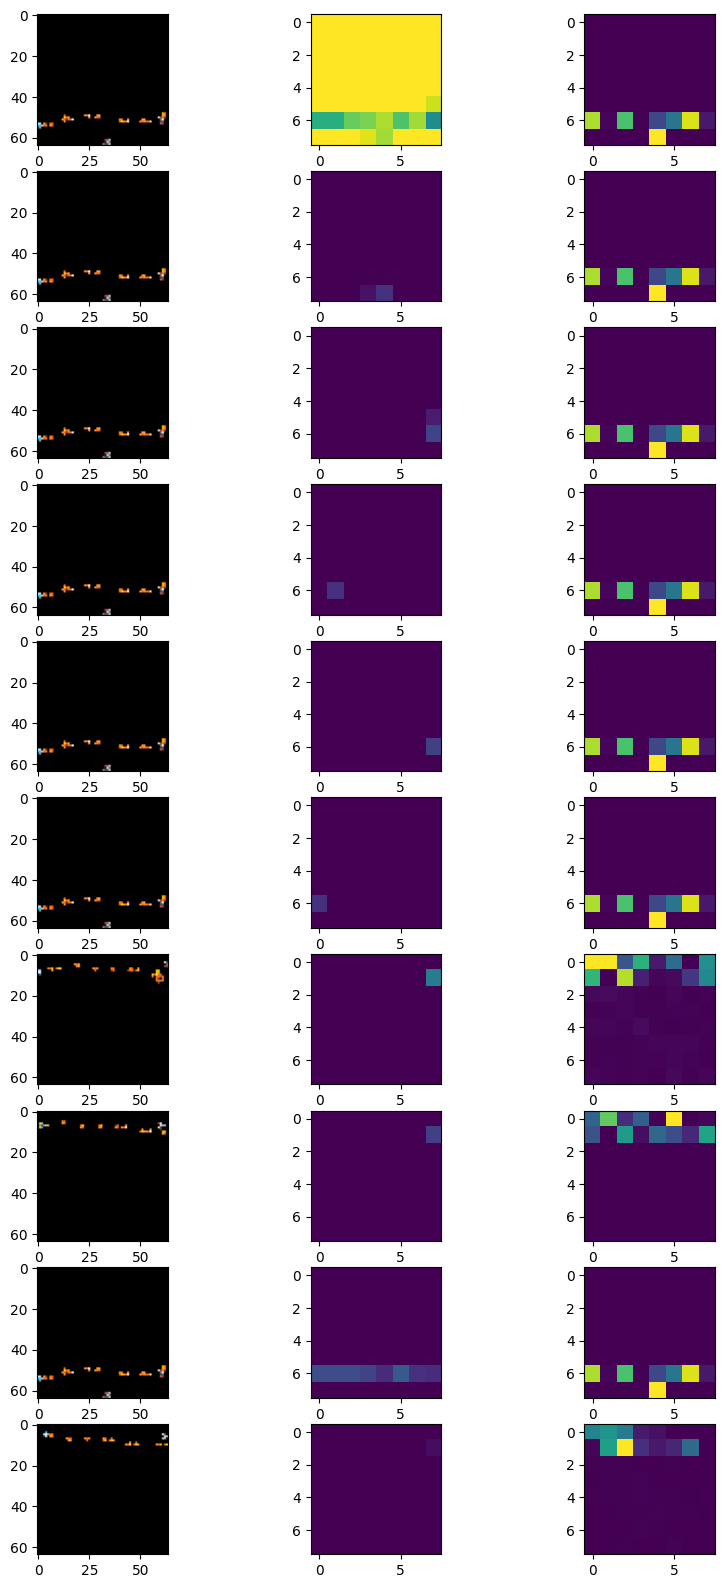

In [20]:
# show examples
fig, axs = plt.subplots(10, 3, figsize=(10, 20))

for i in range(10):
    if examples[i] != -1:
        axs[i, 0].imshow(observations[examples[i]][:,:,6:])
        axs[i, 1].imshow(segmented[examples[i]][:,:,i], vmin=0, vmax=1)
        axs[i, 2].imshow(attention_maps_segmented[examples[i]][:,:,:])
    else:
        axs[i, 0].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        axs[i, 1].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        axs[i, 2].imshow(np.zeros((64, 64, 3), dtype=np.uint8))

In [21]:
features_names = [
    "bg",
    "enemy",
    "enemy_bullet",
    "enemy2",
    "enemy_fire",
    "player",
    "explosion",
    "enemy_fire",
    "player_bullet",
    "enemy_bullet",
]

In [22]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

In [23]:
print(attention_maps_segmented.shape)
print(segmented.shape)

(50000, 8, 8, 1)
(50000, 8, 8, 10)


In [24]:
# flatten the segmented and attention maps. take 16 features from segmented where attention map is highest.
# Flatten the attention maps for easier indexing


def get_featutures(NO_FEATURES=16):
    num_samples = len(attention_maps_segmented)
    flattened_attention = np.squeeze(attention_maps_segmented, axis=-1).reshape(num_samples, -1)  # Shape: (50000, 64)

    # Create array to store the features
    X = np.zeros((num_samples, NO_FEATURES * 10), dtype=np.float32)
    y = actions  # Using actions as the target variable

    # For each sample, find the 16 positions with highest attention
    for i in range(len(flattened_attention)):
        # Get indices of top 16 attention values
        top_indices = np.argsort(flattened_attention[i])[-NO_FEATURES:]
        
        # Convert flattened indices back to 2D positions
        positions = [(idx // 8, idx % 8) for idx in top_indices]
        
        # Extract the segmented features at those positions and store in X
        feature_idx = 0
        for row, col in positions:
            X[i, feature_idx:feature_idx + 10] = segmented[i, row, col]
            feature_idx += 10

    
    return X, y
X, y = get_featutures(NO_FEATURES=10)
X.shape, y.shape


((50000, 100), (50000,))

In [25]:
actions = np.array(actions)

# [4] NOOP
# [5] UP
# [3] DOWN
# [1] LEFT
# [7] RIGHT
# [11] FIRE
# [12] FIRE
# [10] FIRE BACK
# [9]  FIRE 
# other ignored

# collapes actions into 5 classes (UP, DOWN, LEFT, RIGHT, [FIRE, FIRE BACK])
action_map = {
    0: 4,
    1: 1,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 4,
    7: 7,
    8: 4,
    9: 9,
    10: 9,
    11: 9,
    12: 9,
    13: 4,
    14: 4,
}

# collapse actions
y_collapsed = np.zeros(y.shape, dtype=np.int32)
for i in range(len(y)):
    y_collapsed[i] = action_map[y[i]]

x_collapsed = np.zeros((X.shape[0], X.shape[1]), dtype=np.float32)
for i in range(len(X)):
    x_collapsed[i] = X[i]

y_collapsed_f = y_collapsed[y_collapsed != 4]
x_collapsed_f = x_collapsed[y_collapsed != 4]

y_collapsed_f.shape, x_collapsed_f.shape


((26265,), (26265, 100))

In [26]:
# train tree now
model = tree.DecisionTreeClassifier(max_leaf_nodes=50, max_depth=5)



X_train, X_test, y_train, y_test = train_test_split(x_collapsed_f, y_collapsed_f, test_size=0.2, random_state=42)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))

Accuracy: 0.7915476870359794
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       154
           3       0.43      0.03      0.06       632
           5       0.42      0.07      0.12       297
           7       0.00      0.00      0.00        32
           9       0.80      0.99      0.89      4138

    accuracy                           0.79      5253
   macro avg       0.33      0.22      0.21      5253
weighted avg       0.70      0.79      0.71      5253

Report Train
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       646
           3       0.42      0.03      0.06      2537
           5       0.58      0.11      0.18      1122
           7       0.00      0.00      0.00       168
           9       0.80      1.00      0.89     16539

    accuracy                           0.79     21012
   macro avg       0.36      0.23      0.23     21012
weighted avg       0.71      0.79  

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [27]:
# train this model on features from 1 to 32
# metrics
reports=  []
for i in range(1, 33):
    X, y = get_featutures(NO_FEATURES=i)
    y_collapsed = np.zeros(y.shape, dtype=np.int32)
    for i in range(len(y)):
        y_collapsed[i] = action_map[y[i]]

    x_collapsed = np.zeros((X.shape[0], X.shape[1]), dtype=np.float32)
    for i in range(len(X)):
        x_collapsed[i] = X[i]

    y_collapsed_f = y_collapsed[y_collapsed != 4]
    x_collapsed_f = x_collapsed[y_collapsed != 4]   
    
    model = tree.DecisionTreeClassifier()
    X_train, X_test, y_train, y_test = train_test_split(x_collapsed_f, y_collapsed_f, test_size=0.2, random_state=42)

    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)
    print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7774604987626118
Accuracy: 0.7363411383971065
Accuracy: 0.6898914905768132
Accuracy: 0.6767561393489434
Accuracy: 0.6843708357129259
Accuracy: 0.6778983438035409
Accuracy: 0.6843708357129259
Accuracy: 0.6837997334856273
Accuracy: 0.6801827527127355
Accuracy: 0.6881781838949171
Accuracy: 0.6767561393489434
Accuracy: 0.6862745098039216
Accuracy: 0.6807538549400343
Accuracy: 0.6879878164858176
Accuracy: 0.6986483913953931
Accuracy: 0.6917951646678089
Accuracy: 0.6887492861222159
Accuracy: 0.6858937749857225
Accuracy: 0.6815153245764325
Accuracy: 0.6881781838949171
Accuracy: 0.6836093660765277
Accuracy: 0.6887492861222159
Accuracy: 0.687797449076718
Accuracy: 0.6868456120312203
Accuracy: 0.6815153245764325
Accuracy: 0.6805634875309347
Accuracy: 0.6839901008947268
Accuracy: 0.6866552446221207
Accuracy: 0.6931277365315058
Accuracy: 0.6845612031220255
Accuracy: 0.6866552446221207
Accuracy: 0.6853226727584237


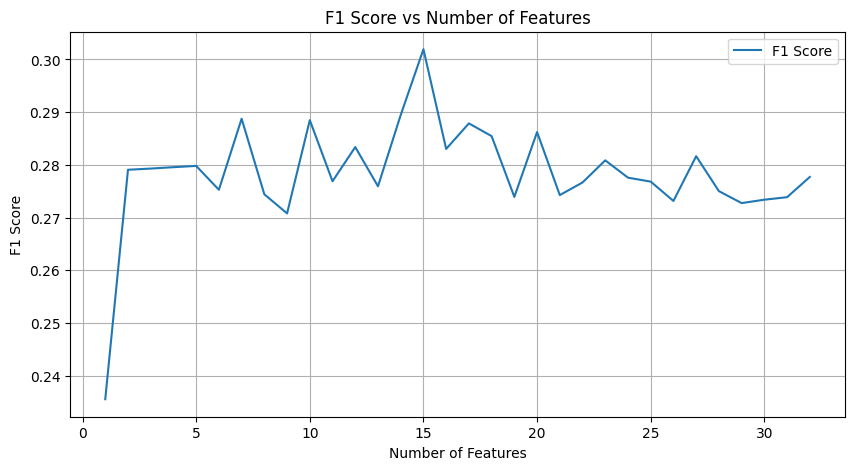

In [28]:
# plot f1
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 33), [report["macro avg"]["f1-score"] for report in reports], label="F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Number of Features")
plt.legend()
plt.grid()
plt.show()

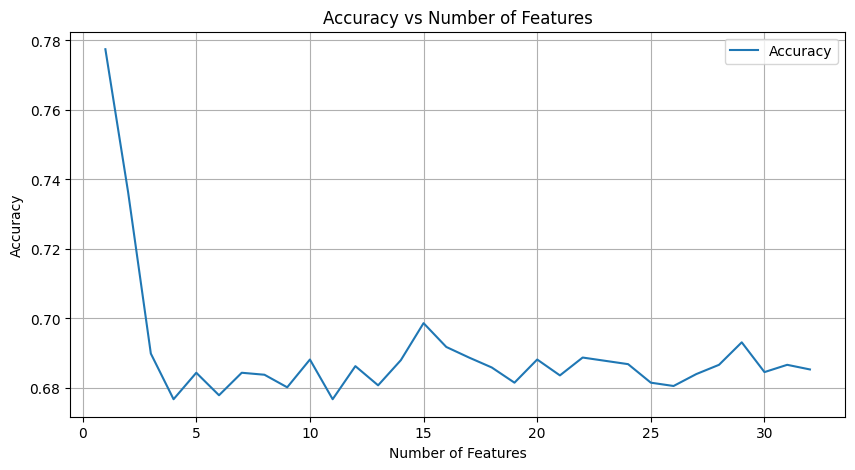

In [37]:
# plot Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, 33), [report["accuracy"] for report in reports], label="Accuracy")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Features")
plt.legend()
plt.grid()
plt.show()

In [29]:
actions = np.array(actions)

action_map = {
    0: 4,
    1: 4,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 4,
    7: 4,
    8: 4,
    9: 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
}
actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]

X_up_down = segmented.reshape(-1, segmented.shape[1]*segmented.shape[2]*segmented.shape[3])
y_up_down = actions_maped
# weight so that all classes are equal
unique_classes = np.unique(y_up_down, return_counts=True)
# calculate balance weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_up_down = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_up_down = {
    3: class_weights_up_down[0],
    4: class_weights_up_down[1]/2,
    5: class_weights_up_down[2],
}
print(class_weights_up_down)
print(class_weights_up_down)

# LEFT/RIGHT NONE dataset
action_map = {
    0: 4,
    1: 1,
    2: 4,
    3: 4,
    4: 4,
    5: 5,
    6: 4,
    7: 7,
    8: 4,
    9: 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
}

actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]
actions_filted = actions_maped[actions_maped != 4]
segmented_filtred = segmented[actions_maped != 4]

X_left_right = segmented_filtred.reshape(-1, segmented_filtred.shape[1]*segmented_filtred.shape[2]*segmented_filtred.shape[3])
y_left_right = actions_filted

# weight so that all classes are equal
unique_classes = np.unique(y_left_right, return_counts=True)
# calculate balance weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_left_right = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# FIRE NONE dataset
action_map = {
    0: 4,
    1: 4,
    2: 4,
    3: 4,
    4: 4,
    5: 4,
    6: 4,
    7: 4,
    8: 4,
    9: 9,
    10: 9,
    11: 9,
    12: 9,
    13: 4,
    14: 4,
}
actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]

actions_filted = actions_maped[actions_maped != 4]
segmented_filtred = segmented[actions_maped != 4]
X_fire = segmented_filtred.reshape(-1, segmented_filtred.shape[1]*segmented_filtred.shape[2]*segmented_filtred.shape[3])
y_fire = actions_filted

{3: 6.505263157894737, 4: 0.8282223098147419, 5: 3.7454545454545456}
{3: 6.505263157894737, 4: 0.8282223098147419, 5: 3.7454545454545456}


In [30]:
import pandas as pd

In [31]:
model = tree.DecisionTreeClassifier(
    class_weight=class_weights_up_down
)

x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": range(1, 10, 1),
        "max_depth": [2, 3, 5],
    },
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_up_down, y_up_down)
params = pd.DataFrame(x.cv_results_)
params.sort_values(by=["rank_test_score", "param_max_leaf_nodes"], ascending=[True, True], inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_p

,params,mean_test_score,rank_test_score
23,"{'max_depth': 5, 'max_leaf_nodes': 6}",0.354364,1
24,"{'max_depth': 5, 'max_leaf_nodes': 7}",0.354364,1
25,"{'max_depth': 5, 'max_leaf_nodes': 8}",0.354250,3
26,"{'max_depth': 5, 'max_leaf_nodes': 9}",0.354250,3
1,"{'max_depth': 2, 'max_leaf_nodes': 2}",0.317305,5
10,"{'max_depth': 3, 'max_leaf_nodes': 2}",0.317305,5
19,"{'max_depth': 5, 'max_leaf_nodes': 2}",0.317305,5
2,"{'max_depth': 2, 'max_leaf_nodes': 3}",0.317305,5
11,"{'max_depth': 3, 'max_leaf_nodes': 3}",0.317305,5
20,"{'max_depth': 5, 'max_leaf_nodes': 3}",0.317305,5


In [32]:
best_model = tree.DecisionTreeClassifier(max_depth=3, max_leaf_nodes=8, class_weight=class_weights_up_down)
best_model = best_model.fit(X_up_down, y_up_down, sample_weight=np.where(y_up_down != 4, np.ones(y_up_down.shape), 0.05))
y_pred = best_model.predict(X_up_down)
y_pred_train = best_model.predict(X_up_down)

print("Report Test")
print(classification_report(y_up_down, y_pred))
print("Report Train")
print(classification_report(y_up_down, y_pred_train))

Report Test
              precision    recall  f1-score   support

           3       0.07      1.00      0.12      3169
           4       1.00      0.03      0.07     45412
           5       0.06      0.01      0.02      1419

    accuracy                           0.10     50000
   macro avg       0.37      0.35      0.07     50000
weighted avg       0.91      0.10      0.07     50000

Report Train
              precision    recall  f1-score   support

           3       0.07      1.00      0.12      3169
           4       1.00      0.03      0.07     45412
           5       0.06      0.01      0.02      1419

    accuracy                           0.10     50000
   macro avg       0.37      0.35      0.07     50000
weighted avg       0.91      0.10      0.07     50000



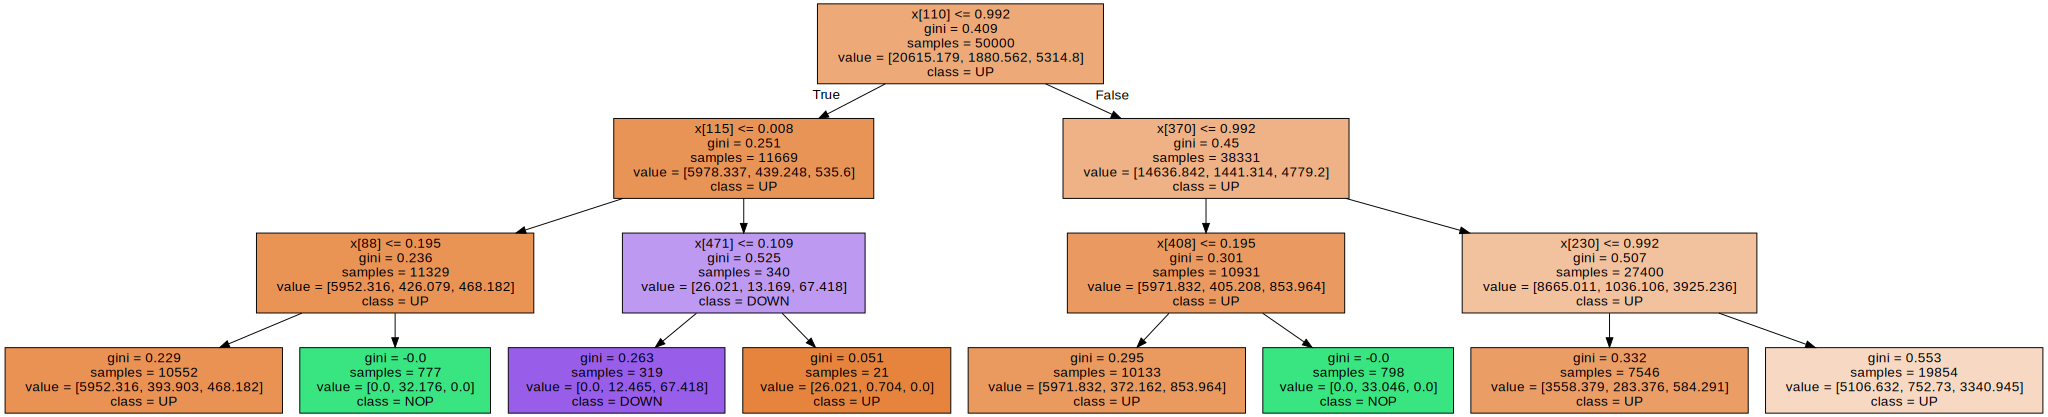

In [33]:
# plot tree

import graphviz

dot_data = tree.export_graphviz(best_model, out_file=None,
                                class_names=["UP", "NOP", "DOWN"],
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, filename=None, format="png")
graph
